In [1]:
import ROOT
import sys
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy import stats

Welcome to JupyROOT 6.26/04


In [2]:
#  caen_muon_v01d_multi_files
#  This version is for Run >= 71,  which uses Tref [-75:-25] 

csvname="/Users/kunori/skdir/CAEN/dfiles/MuonTestStand/Run28_list.csv"

# Cde updated for Tref 50 ns, Tref shift -75 ns

# runlist = np.arange(30,40,1,dtype=int)
# runlist = np.arange(41,49,1,dtype=int)
runlist = np.arange(240,250,1,dtype=int)

nhitDisplayMax=10     # number of events to display hits per run.
nmaxEventsPerRun=100000    # number of events to analyze per run

# rangeTOA=np.array([60.0,90.0])  # for RUn 180-189
# rangeTOA=np.array([150,200.0])   # for RUn 200, 201 with OR32-AND2
rangeTOA=np.array([120,160.0])   # for RUn 202,203, 204  with MJ32(2)-AND2

#  == constants,  channel map etc ==
#  pre-set for pdf plot file name
prepdf="plotdir/plotMTS_run"+str(runlist[0])+"_"
postpdf=".pdf"

csvdir="/Users/kunori/skdir/CAEN/dfiles/MuonTestStand/"

# global valiables
totalEventCount=0
runEventCount=np.zeros(len(runlist))
h1={}
h2={}
hp={}


sipm2caen=np.array([61,63,32,34,29,31,0,2,
          59,57,38,36,27,25,6,4,
          53,55,40,42,21,23,8,10,
          51,49,46,44,19,17,14,12,
          45,47,48,50,13,15,16,18,
          43,41,54,52,11,9,22,20,
          37,39,56,58,5,7,24,26,
          35,33,62,60,3,1,30,28])

caen2sipm=np.zeros(64,dtype=int)
for i in range(0,64):
    k=i 
    caen2sipm[sipm2caen[k]]=i

    
#  x:  left to right
#  y:  bottom to top
xy2caen=np.array([35,37,43,45,51,53,59,61,
                   33,39,41,47,49,55,57,63,
                   62,56,54,48,46,40,38,32,
                   60,58,52,50,44,42,36,34,
                   3,5,11,13,19,21,27,29,
                   1,7,9,15,17,23,25,31,
                   30,24,22,16,14,8,6,0,
                   28,26,20,18,12,10,4,2])

caen2xy=np.zeros(64,dtype=int)
for i in range(0,64):
    k=i 
    caen2xy[xy2caen[k]]=i

        
print("caen2sipm",caen2sipm)
print("caen2xy",caen2xy)



caen2sipm [ 6 61  7 60 15 52 14 53 22 45 23 44 31 36 30 37 38 29 39 28 47 20 46 21
 54 13 55 12 63  4 62  5  2 57  3 56 11 48 10 49 18 41 19 40 27 32 26 33
 34 25 35 24 43 16 42 17 50  9 51  8 59  0 58  1]
caen2xy [55 40 63 32 62 33 54 41 53 42 61 34 60 35 52 43 51 44 59 36 58 37 50 45
 49 46 57 38 56 39 48 47 23  8 31  0 30  1 22  9 21 10 29  2 28  3 20 11
 19 12 27  4 26  5 18 13 17 14 25  6 24  7 16 15]


In [3]:
def unpackData(row):
    rtcode=0
    BoardID=int(row[0])
    TStamp=float(row[1])
    nHits=int(row[2])
    # nHits=64
    
    LG=np.zeros(64)
    HG=np.zeros(64)
    TOA=np.zeros(64)
    TOT=np.zeros(64)
    data_type=np.zeros(64,dtype=int)
    
    i=4
    while i<len(row):
        chid=int(row[i])
        dtype=str(row[i+1])
        # print(chid,dtype,LG[chid],HG[chid])
        i=i+2
        if dtype == "0x10":
            TOA[chid]=float(row[i])
            TOT[chid]=0.0
            LG[chid]=0.0
            HG[chid]=0.0
            i=i+1
            data_type[chid]=4
        elif dtype == "0x20":
            TOA[chid]=0.0
            TOT[chid]=float(row[i])
            LG[chid]=0.0
            HG[chid]=0.0
            i=i+1
            data_type[chid]=5
        elif dtype == "0x30":
            TOA[chid]=float(row[i])
            TOT[chid]=float(row[i+1])
            LG[chid]=0.0
            HG[chid]=0.0
            i=i+2
            data_type[chid]=6
        elif dtype == "0x3":
            LG[chid]=float(row[i])
            HG[chid]=float(row[i+1])
            TOA[chid]=0.0
            TOT[chid]=0.0
            i=i+2
            data_type[chid]=1
        elif dtype == "0x13":
            LG[chid]=float(row[i])
            HG[chid]=float(row[i+1])
            TOA[chid]=float(row[i+2])
            TOT[chid]=0.0
            data_type[chid]=2
            i=i+3
        elif dtype == "0x23":
            LG[chid]=float(row[i])
            HG[chid]=float(row[i+1])
            TOA[chid]=0.0
            TOT[chid]=float(row[i+2])
            data_type[chid]=2
            i=i+3
        elif dtype == "0x33":
            LG[chid]=float(row[i])
            HG[chid]=float(row[i+1])
            TOA[chid]=float(row[i+2])
            TOT[chid]=float(row[i+3])
            data_type[chid]=3
            i=i+4
        else:
            data_type[chid]=8
            print("unpackData:  unkown data_type",dtype)
            print(row)
            rtcode=1
        
    # print(BoardID,TStamp)
    return rtcode,TStamp,LG,HG,TOA,TOT,data_type
    
    

start analyzing Run 240
/Users/kunori/skdir/CAEN/dfiles/MuonTestStand/Run240_list.csv
run 240  eventCount= 4
i 9  kx 2 ky 5 TOA 142.0 TOT 16.0    intime
i 11  kx 2 ky 4 TOA 141.0 TOT 18.0    intime
i 45  kx 3 ky 0 TOA 140.0 TOT 23.0    intime
i 47  kx 3 ky 1 TOA 131.0 TOT 35.0    intime
run 240  eventCount= 4 (orange: TOA intime)
s_x -0.235 i_x  3.088  err  0.042 r -0.970


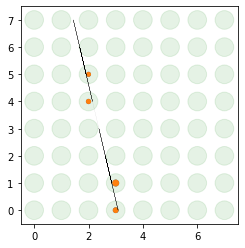

run 240  eventCount= 8
i 16  kx 3 ky 6 TOA 157.0 TOT 19.0    intime
i 22  kx 2 ky 6 TOA 143.0 TOT 16.0    intime
i 46  kx 4 ky 2 TOA 154.0 TOT 22.0    intime
i 48  kx 3 ky 2 TOA 151.0 TOT 34.0    intime
run 240  eventCount= 8 (orange: TOA intime)
s_x -0.250 i_x  4.000  err  0.177 r -0.707


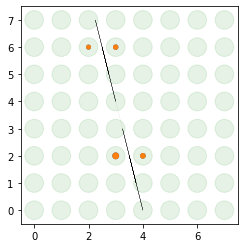

run 240  eventCount= 14
i 6  kx 6 ky 6 TOA 153.0 TOT 19.0    intime
i 10  kx 5 ky 7 TOA 146.0 TOT 32.0    intime
i 40  kx 5 ky 2 TOA 156.0 TOT 13.0    intime
i 45  kx 3 ky 0 TOA 138.0 TOT 76.0    intime
i 47  kx 3 ky 1 TOA 142.0 TOT 44.0    intime
i 49  kx 4 ky 1 TOA 144.0 TOT 40.0    intime
run 240  eventCount= 14 (orange: TOA intime)
s_x  0.335 i_x  3.385  err  0.122 r  0.809


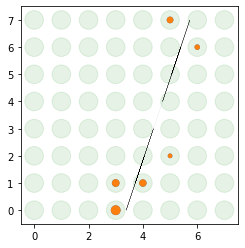

run 240  eventCount= 23
i 4  kx 6 ky 7 TOA 135.0 TOT 33.0    intime
i 25  kx 6 ky 5 TOA 127.0 TOT 64.0    intime
i 59  kx 6 ky 0 TOA 151.0 TOT 20.0    intime
i 63  kx 7 ky 1 TOA 125.0 TOT 55.0    intime
run 240  eventCount= 23 (orange: TOA intime)
s_x -0.069 i_x  6.473  err  0.095 r -0.454


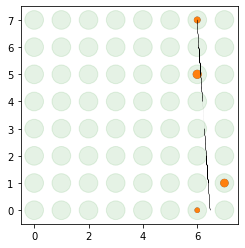

run 240  eventCount= 29
i 12  kx 4 ky 7 TOA 142.0 TOT 43.0    intime
i 15  kx 3 ky 5 TOA 140.0 TOT 35.0    intime
i 45  kx 3 ky 0 TOA 136.0 TOT 50.0    intime
i 46  kx 4 ky 2 TOA 139.0 TOT 36.0    intime
i 51  kx 4 ky 0 TOA 142.0 TOT 24.0    intime
run 240  eventCount= 29 (orange: TOA intime)
s_x  0.015 i_x  3.557  err  0.101 r  0.088


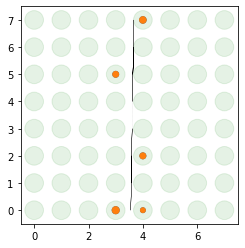

run 240  eventCount= 30
i 5  kx 1 ky 4 TOA 148.0 TOT 31.0    intime
i 12  kx 4 ky 7 TOA 147.0 TOT 28.0    intime
i 13  kx 3 ky 4 TOA 146.0 TOT 32.0    intime
i 14  kx 4 ky 6 TOA 152.0 TOT 16.0    intime
i 15  kx 3 ky 5 TOA 144.0 TOT 41.0    intime
i 45  kx 3 ky 0 TOA 146.0 TOT 41.0    intime
i 47  kx 3 ky 1 TOA 140.0 TOT 41.0    intime
run 240  eventCount= 30 (orange: TOA intime)
s_x  0.129 i_x  2.504  err  0.166 r  0.327


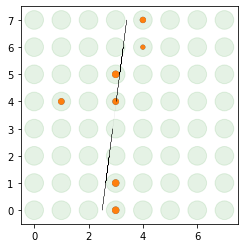

run 240  eventCount= 33
i 7  kx 1 ky 5 TOA 141.0 TOT 41.0    intime
i 11  kx 2 ky 4 TOA 145.0 TOT 31.0    intime
i 48  kx 3 ky 2 TOA 147.0 TOT 26.0    intime
i 55  kx 5 ky 1 TOA 143.0 TOT 33.0    intime
run 240  eventCount= 33 (orange: TOA intime)
s_x -0.900 i_x  5.450  err  0.180 r -0.962


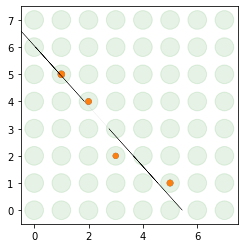

run 240  eventCount= 47
i 10  kx 5 ky 7 TOA 178.0 TOT 62.0     
i 12  kx 4 ky 7 TOA 160.0 TOT 61.0    intime
i 14  kx 4 ky 6 TOA 167.0 TOT 49.0     
i 15  kx 3 ky 5 TOA 146.0 TOT 53.0    intime
i 17  kx 4 ky 5 TOA 146.0 TOT 88.0    intime
i 19  kx 4 ky 4 TOA 184.0 TOT 66.0     
i 54  kx 2 ky 2 TOA 153.0 TOT 50.0    intime
i 56  kx 1 ky 2 TOA 145.0 TOT 60.0    intime
i 57  kx 6 ky 1 TOA 176.0 TOT 18.0     
i 61  kx 7 ky 0 TOA 164.0 TOT 50.0     
i 63  kx 7 ky 1 TOA 200.0 TOT 34.0     
run 240  eventCount= 47 (orange: TOA intime)
s_x  0.543 i_x  0.521  err  0.150 r  0.902


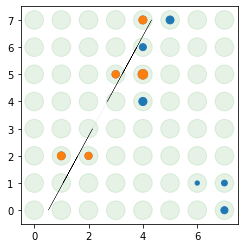

Run 240 ,   665  events have been analyzed.
start analyzing Run 241
/Users/kunori/skdir/CAEN/dfiles/MuonTestStand/Run241_list.csv
run 241  eventCount= 6
i 6  kx 6 ky 6 TOA 154.0 TOT 21.0    intime
i 10  kx 5 ky 7 TOA 144.0 TOT 49.0    intime
i 55  kx 5 ky 1 TOA 147.0 TOT 33.0    intime
i 59  kx 6 ky 0 TOA 151.0 TOT 36.0    intime
run 241  eventCount= 6 (orange: TOA intime)
s_x -0.027 i_x  5.595  err  0.115 r -0.164


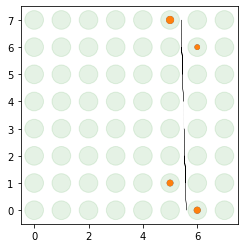

run 241  eventCount= 11
i 18  kx 3 ky 7 TOA 155.0 TOT 32.0    intime
i 19  kx 4 ky 4 TOA 157.0 TOT 30.0    intime
i 49  kx 4 ky 1 TOA 149.0 TOT 49.0    intime
i 50  kx 3 ky 3 TOA 154.0 TOT 43.0    intime
i 51  kx 4 ky 0 TOA 151.0 TOT 38.0    intime
run 241  eventCount= 11 (orange: TOA intime)
s_x -0.133 i_x  4.000  err  0.086 r -0.667


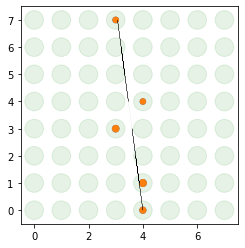

run 241  eventCount= 18
i 9  kx 2 ky 5 TOA 142.0 TOT 30.0    intime
i 15  kx 3 ky 5 TOA 142.0 TOT 27.0    intime
i 57  kx 6 ky 1 TOA 135.0 TOT 39.0    intime
i 59  kx 6 ky 0 TOA 132.0 TOT 44.0    intime
run 241  eventCount= 18 (orange: TOA intime)
s_x -0.759 i_x  6.337  err  0.138 r -0.968


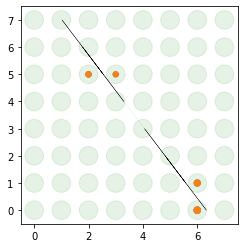

run 241  eventCount= 21
i 27  kx 6 ky 4 TOA 125.0 TOT 60.0    intime
i 31  kx 7 ky 5 TOA 140.0 TOT 20.0    intime
i 47  kx 3 ky 1 TOA 128.0 TOT 38.0    intime
i 48  kx 3 ky 2 TOA 128.0 TOT 34.0    intime
run 241  eventCount= 21 (orange: TOA intime)
s_x  1.100 i_x  1.450  err  0.180 r  0.974


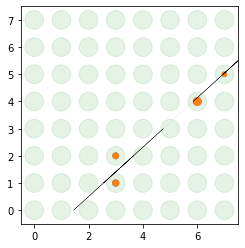

run 241  eventCount= 386
i 0  kx 7 ky 6 TOA 142.0 TOT 56.0    intime
i 21  kx 5 ky 4 TOA 157.0 TOT 20.0    intime
i 23  kx 5 ky 5 TOA 157.0 TOT 21.0    intime
i 45  kx 3 ky 0 TOA 147.0 TOT 44.0    intime
i 49  kx 4 ky 1 TOA 147.0 TOT 36.0    intime
i 51  kx 4 ky 0 TOA 138.0 TOT 66.0    intime
i 53  kx 5 ky 0 TOA 157.0 TOT 19.0    intime
run 241  eventCount= 386 (orange: TOA intime)
s_x  0.376 i_x  3.855  err  0.131 r  0.788


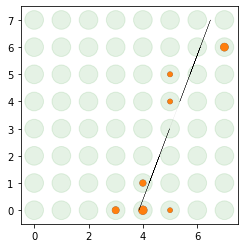

Run 241 ,   635  events have been analyzed.
start analyzing Run 242
/Users/kunori/skdir/CAEN/dfiles/MuonTestStand/Run242_list.csv
run 242  eventCount= 3
i 28  kx 0 ky 7 TOA 157.0 TOT 34.0    intime
i 30  kx 0 ky 6 TOA 155.0 TOT 31.0    intime
i 60  kx 0 ky 3 TOA 151.0 TOT 39.0    intime
i 62  kx 0 ky 2 TOA 150.0 TOT 43.0    intime
run 242  eventCount= 3 (orange: TOA intime)
s_x  0.000 i_x  0.000  err  0.000 r  0.000


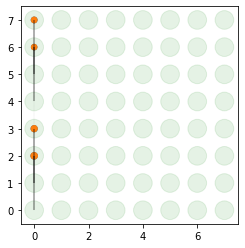

run 242  eventCount= 5
i 16  kx 3 ky 6 TOA 139.0 TOT 31.0    intime
i 18  kx 3 ky 7 TOA 148.0 TOT 11.0    intime
i 48  kx 3 ky 2 TOA 127.0 TOT 54.0    intime
i 50  kx 3 ky 3 TOA 135.0 TOT 41.0    intime
run 242  eventCount= 5 (orange: TOA intime)
s_x  0.000 i_x  3.000  err  0.000 r  0.000


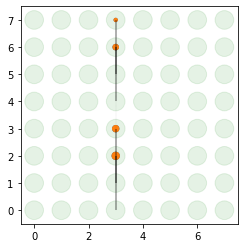

run 242  eventCount= 6
i 17  kx 4 ky 5 TOA 145.0 TOT 45.0    intime
i 18  kx 3 ky 7 TOA 150.0 TOT 31.0    intime
i 22  kx 2 ky 6 TOA 157.0 TOT 26.0    intime
i 44  kx 4 ky 3 TOA 151.0 TOT 35.0    intime
i 47  kx 3 ky 1 TOA 149.0 TOT 35.0    intime
i 48  kx 3 ky 2 TOA 146.0 TOT 32.0    intime
i 50  kx 3 ky 3 TOA 156.0 TOT 20.0    intime
run 242  eventCount= 6 (orange: TOA intime)
s_x -0.064 i_x  3.391  err  0.138 r -0.205


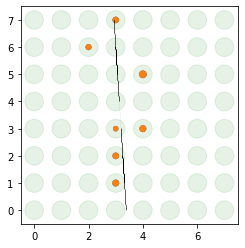

run 242  eventCount= 8
i 14  kx 4 ky 6 TOA 143.0 TOT 19.0    intime
i 17  kx 4 ky 5 TOA 130.0 TOT 55.0    intime
i 58  kx 1 ky 3 TOA 132.0 TOT 44.0    intime
i 62  kx 0 ky 2 TOA 133.0 TOT 43.0    intime
run 242  eventCount= 8 (orange: TOA intime)
s_x  1.100 i_x -2.150  err  0.180 r  0.974


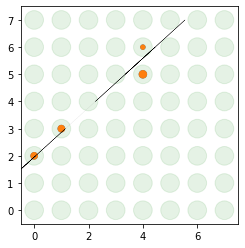

Run 242 ,   649  events have been analyzed.
start analyzing Run 243
/Users/kunori/skdir/CAEN/dfiles/MuonTestStand/Run243_list.csv
run 243  eventCount= 4
i 12  kx 4 ky 7 TOA 149.0 TOT 42.0    intime
i 13  kx 3 ky 4 TOA 152.0 TOT 30.0    intime
i 44  kx 4 ky 3 TOA 150.0 TOT 38.0    intime
i 47  kx 3 ky 1 TOA 153.0 TOT 21.0    intime
run 243  eventCount= 4 (orange: TOA intime)
s_x  0.133 i_x  3.000  err  0.133 r  0.577


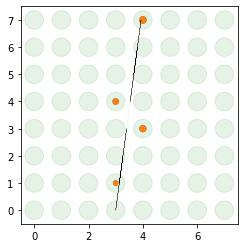

run 243  eventCount= 9
i 4  kx 6 ky 7 TOA 223.0 TOT 42.0     
i 10  kx 5 ky 7 TOA 148.0 TOT 118.0    intime
i 12  kx 4 ky 7 TOA 149.0 TOT 107.0    intime
i 13  kx 3 ky 4 TOA 160.0 TOT 36.0    intime
i 14  kx 4 ky 6 TOA 146.0 TOT 102.0    intime
i 15  kx 3 ky 5 TOA 158.0 TOT 82.0    intime
i 16  kx 3 ky 6 TOA 210.0 TOT 20.0     
i 17  kx 4 ky 5 TOA 156.0 TOT 59.0    intime
i 46  kx 4 ky 2 TOA 159.0 TOT 43.0    intime
i 47  kx 3 ky 1 TOA 156.0 TOT 44.0    intime
i 48  kx 3 ky 2 TOA 152.0 TOT 73.0    intime
i 49  kx 4 ky 1 TOA 173.0 TOT 22.0     
i 50  kx 3 ky 3 TOA 147.0 TOT 86.0    intime
i 54  kx 2 ky 2 TOA 150.0 TOT 85.0    intime
i 55  kx 5 ky 1 TOA 148.0 TOT 53.0    intime
run 243  eventCount= 9 (orange: TOA intime)
s_x  0.143 i_x  3.048  err  0.120 r  0.352


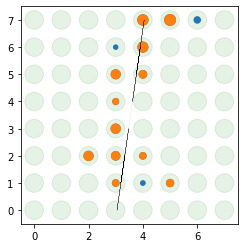

Run 243 ,   635  events have been analyzed.
start analyzing Run 244
/Users/kunori/skdir/CAEN/dfiles/MuonTestStand/Run244_list.csv
run 244  eventCount= 1
i 17  kx 4 ky 5 TOA 145.0 TOT 29.0    intime
i 22  kx 2 ky 6 TOA 151.0 TOT 14.0    intime
i 32  kx 7 ky 2 TOA 138.0 TOT 35.0    intime
i 36  kx 6 ky 3 TOA 141.0 TOT 43.0    intime
run 244  eventCount= 1 (orange: TOA intime)
s_x -1.200 i_x  9.550  err  0.132 r -0.988


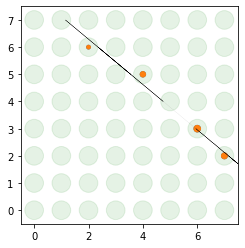

run 244  eventCount= 12
i 13  kx 3 ky 4 TOA 138.0 TOT 50.0    intime
i 14  kx 4 ky 6 TOA 146.0 TOT 32.0    intime
i 45  kx 3 ky 0 TOA 152.0 TOT 23.0    intime
i 46  kx 4 ky 2 TOA 148.0 TOT 36.0    intime
i 47  kx 3 ky 1 TOA 146.0 TOT 34.0    intime
run 244  eventCount= 12 (orange: TOA intime)
s_x  0.121 i_x  3.086  err  0.111 r  0.531


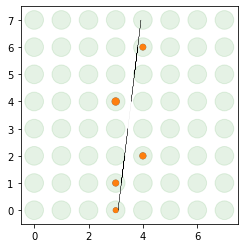

Run 244 ,   668  events have been analyzed.
start analyzing Run 245
/Users/kunori/skdir/CAEN/dfiles/MuonTestStand/Run245_list.csv
run 245  eventCount= 6
i 8  kx 5 ky 6 TOA 147.0 TOT 28.0    intime
i 10  kx 5 ky 7 TOA 147.0 TOT 31.0    intime
i 12  kx 4 ky 7 TOA 154.0 TOT 13.0    intime
i 44  kx 4 ky 3 TOA 152.0 TOT 29.0    intime
i 46  kx 4 ky 2 TOA 150.0 TOT 23.0    intime
run 245  eventCount= 6 (orange: TOA intime)
s_x  0.136 i_x  3.718  err  0.109 r  0.584


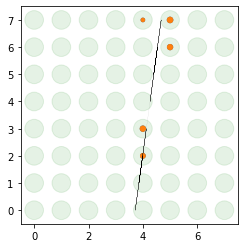

Run 245 ,   660  events have been analyzed.
start analyzing Run 246
/Users/kunori/skdir/CAEN/dfiles/MuonTestStand/Run246_list.csv
run 246  eventCount= 10
i 13  kx 3 ky 4 TOA 156.0 TOT 61.0    intime
i 14  kx 4 ky 6 TOA 155.0 TOT 47.0    intime
i 15  kx 3 ky 5 TOA 152.0 TOT 70.0    intime
i 44  kx 4 ky 3 TOA 154.0 TOT 76.0    intime
i 46  kx 4 ky 2 TOA 149.0 TOT 88.0    intime
run 246  eventCount= 10 (orange: TOA intime)
s_x -0.100 i_x  4.000  err  0.191 r -0.289


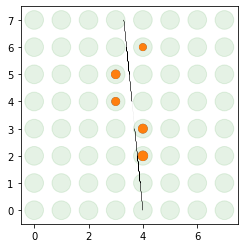

run 246  eventCount= 12
i 9  kx 2 ky 5 TOA 136.0 TOT 64.0    intime
i 13  kx 3 ky 4 TOA 144.0 TOT 38.0    intime
i 48  kx 3 ky 2 TOA 144.0 TOT 36.0    intime
i 53  kx 5 ky 0 TOA 145.0 TOT 36.0    intime
i 55  kx 5 ky 1 TOA 136.0 TOT 63.0    intime
run 246  eventCount= 12 (orange: TOA intime)
s_x -0.593 i_x  5.023  err  0.149 r -0.917


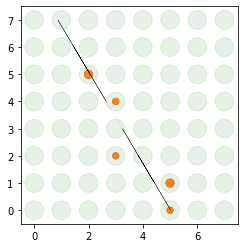

run 246  eventCount= 21
i 14  kx 4 ky 6 TOA 141.0 TOT 41.0    intime
i 15  kx 3 ky 5 TOA 131.0 TOT 47.0    intime
i 45  kx 3 ky 0 TOA 136.0 TOT 34.0    intime
i 46  kx 4 ky 2 TOA 138.0 TOT 22.0    intime
run 246  eventCount= 21 (orange: TOA intime)
s_x  0.066 i_x  3.286  err  0.141 r  0.314


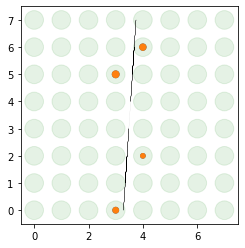

run 246  eventCount= 23
i 12  kx 4 ky 7 TOA 136.0 TOT 28.0    intime
i 17  kx 4 ky 5 TOA 145.0 TOT 225.0    intime
i 19  kx 4 ky 4 TOA 141.0 TOT 25.0    intime
i 53  kx 5 ky 0 TOA 133.0 TOT 35.0    intime
i 55  kx 5 ky 1 TOA 139.0 TOT 18.0    intime
run 246  eventCount= 23 (orange: TOA intime)
s_x -0.175 i_x  4.994  err  0.043 r -0.919


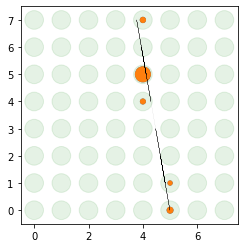

run 246  eventCount= 33
i 13  kx 3 ky 4 TOA 144.0 TOT 38.0    intime
i 14  kx 4 ky 6 TOA 146.0 TOT 31.0    intime
i 45  kx 3 ky 0 TOA 144.0 TOT 46.0    intime
i 46  kx 4 ky 2 TOA 145.0 TOT 35.0    intime
i 47  kx 3 ky 1 TOA 144.0 TOT 33.0    intime
run 246  eventCount= 33 (orange: TOA intime)
s_x  0.121 i_x  3.086  err  0.111 r  0.531


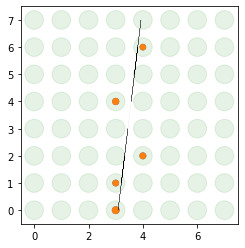

run 246  eventCount= 34
i 12  kx 4 ky 7 TOA 127.0 TOT 45.0    intime
i 15  kx 3 ky 5 TOA 145.0 TOT 17.0    intime
i 46  kx 4 ky 2 TOA 131.0 TOT 40.0    intime
i 47  kx 3 ky 1 TOA 120.0 TOT 59.0    intime
i 49  kx 4 ky 1 TOA 136.0 TOT 21.0    intime
run 246  eventCount= 34 (orange: TOA intime)
s_x  0.014 i_x  3.556  err  0.118 r  0.068


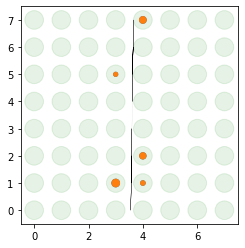

run 246  eventCount= 37
i 6  kx 6 ky 6 TOA 158.0 TOT 16.0    intime
i 16  kx 3 ky 6 TOA 146.0 TOT 55.0    intime
i 17  kx 4 ky 5 TOA 143.0 TOT 74.0    intime
i 21  kx 5 ky 4 TOA 141.0 TOT 97.0    intime
i 23  kx 5 ky 5 TOA 147.0 TOT 59.0    intime
i 27  kx 6 ky 4 TOA 154.0 TOT 32.0    intime
i 47  kx 3 ky 1 TOA 156.0 TOT 18.0    intime
i 48  kx 3 ky 2 TOA 150.0 TOT 35.0    intime
i 49  kx 4 ky 1 TOA 147.0 TOT 43.0    intime
i 53  kx 5 ky 0 TOA 138.0 TOT 108.0    intime
i 54  kx 2 ky 2 TOA 140.0 TOT 75.0    intime
i 55  kx 5 ky 1 TOA 138.0 TOT 113.0    intime
run 246  eventCount= 37 (orange: TOA intime)
s_x  0.152 i_x  3.781  err  0.183 r  0.254


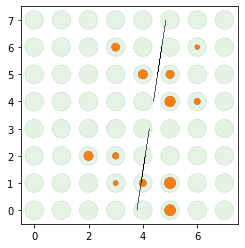

run 246  eventCount= 45
i 18  kx 3 ky 7 TOA 136.0 TOT 43.0    intime
i 22  kx 2 ky 6 TOA 138.0 TOT 39.0    intime
i 60  kx 0 ky 3 TOA 134.0 TOT 43.0    intime
i 62  kx 0 ky 2 TOA 141.0 TOT 29.0    intime
run 246  eventCount= 45 (orange: TOA intime)
s_x  0.618 i_x -1.529  err  0.088 r  0.980


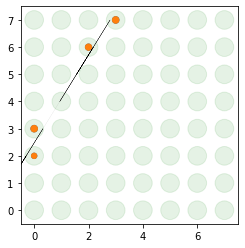

run 246  eventCount= 48
i 4  kx 6 ky 7 TOA 140.0 TOT 36.0    intime
i 15  kx 3 ky 5 TOA 137.0 TOT 42.0    intime
i 58  kx 1 ky 3 TOA 136.0 TOT 44.0    intime
i 62  kx 0 ky 2 TOA 143.0 TOT 21.0    intime
run 246  eventCount= 48 (orange: TOA intime)
s_x  1.186 i_x -2.542  err  0.090 r  0.994


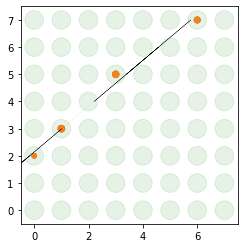

run 246  eventCount= 54
i 17  kx 4 ky 5 TOA 136.0 TOT 27.0    intime
i 18  kx 3 ky 7 TOA 143.0 TOT 19.0    intime
i 32  kx 7 ky 2 TOA 285.0 TOT 28.0     
i 45  kx 3 ky 0 TOA 138.0 TOT 23.0    intime
i 47  kx 3 ky 1 TOA 130.0 TOT 32.0    intime
run 246  eventCount= 54 (orange: TOA intime)
s_x  0.053 i_x  3.076  err  0.100 r  0.353


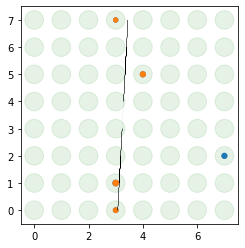

Run 246 ,   660  events have been analyzed.
start analyzing Run 247
/Users/kunori/skdir/CAEN/dfiles/MuonTestStand/Run247_list.csv
Run 247 ,   720  events have been analyzed.
start analyzing Run 248
/Users/kunori/skdir/CAEN/dfiles/MuonTestStand/Run248_list.csv
run 248  eventCount= 5
i 17  kx 4 ky 5 TOA 153.0 TOT 29.0    intime
i 19  kx 4 ky 4 TOA 158.0 TOT 25.0    intime
i 40  kx 5 ky 2 TOA 217.0 TOT 17.0     
i 48  kx 3 ky 2 TOA 153.0 TOT 24.0    intime
i 49  kx 4 ky 1 TOA 141.0 TOT 55.0    intime
run 248  eventCount= 5 (orange: TOA intime)
s_x  0.100 i_x  3.450  err  0.180 r  0.365


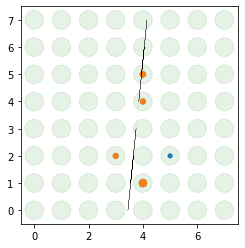

run 248  eventCount= 8
i 4  kx 6 ky 7 TOA 132.0 TOT 57.0    intime
i 8  kx 5 ky 6 TOA 135.0 TOT 40.0    intime
i 50  kx 3 ky 3 TOA 140.0 TOT 41.0    intime
i 54  kx 2 ky 2 TOA 139.0 TOT 39.0    intime
run 248  eventCount= 8 (orange: TOA intime)
s_x  0.765 i_x  0.559  err  0.042 r  0.997


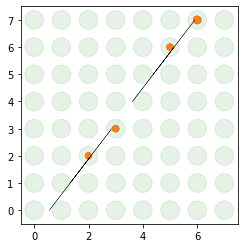

run 248  eventCount= 10
i 16  kx 3 ky 6 TOA 144.0 TOT 45.0    intime
i 17  kx 4 ky 5 TOA 156.0 TOT 20.0    intime
i 18  kx 3 ky 7 TOA 153.0 TOT 22.0    intime
i 51  kx 4 ky 0 TOA 151.0 TOT 23.0    intime
i 54  kx 2 ky 2 TOA 140.0 TOT 49.0    intime
i 55  kx 5 ky 1 TOA 155.0 TOT 14.0    intime
run 248  eventCount= 10 (orange: TOA intime)
s_x -0.133 i_x  3.964  err  0.170 r -0.364


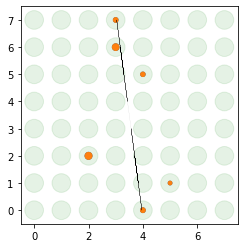

run 248  eventCount= 20
i 1  kx 0 ky 5 TOA 136.0 TOT 53.0    intime
i 5  kx 1 ky 4 TOA 149.0 TOT 24.0    intime
i 48  kx 3 ky 2 TOA 140.0 TOT 34.0    intime
i 53  kx 5 ky 0 TOA 148.0 TOT 21.0    intime
i 61  kx 7 ky 0 TOA 150.0 TOT 10.0    intime
run 248  eventCount= 20 (orange: TOA intime)
s_x -1.212 i_x  5.865  err  0.191 r -0.965


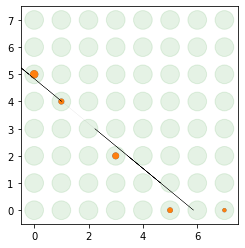

run 248  eventCount= 23
i 0  kx 7 ky 6 TOA 154.0 TOT 33.0    intime
i 2  kx 7 ky 7 TOA 146.0 TOT 49.0    intime
i 55  kx 5 ky 1 TOA 148.0 TOT 22.0    intime
i 59  kx 6 ky 0 TOA 139.0 TOT 45.0    intime
run 248  eventCount= 23 (orange: TOA intime)
s_x  0.230 i_x  5.446  err  0.104 r  0.843


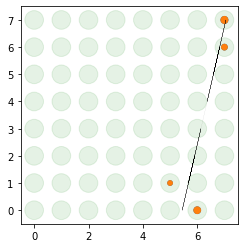

run 248  eventCount= 24
i 9  kx 2 ky 5 TOA 158.0 TOT 19.0    intime
i 12  kx 4 ky 7 TOA 151.0 TOT 35.0    intime
i 19  kx 4 ky 4 TOA 153.0 TOT 38.0    intime
i 49  kx 4 ky 1 TOA 150.0 TOT 35.0    intime
i 50  kx 3 ky 3 TOA 152.0 TOT 41.0    intime
i 51  kx 4 ky 0 TOA 155.0 TOT 23.0    intime
i 55  kx 5 ky 1 TOA 148.0 TOT 41.0    intime
run 248  eventCount= 24 (orange: TOA intime)
s_x -0.158 i_x  4.188  err  0.154 r -0.418


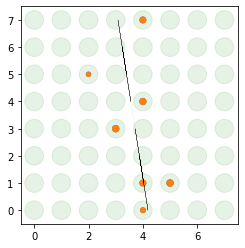

run 248  eventCount= 28
i 17  kx 4 ky 5 TOA 144.0 TOT 45.0    intime
i 19  kx 4 ky 4 TOA 144.0 TOT 47.0    intime
i 48  kx 3 ky 2 TOA 143.0 TOT 43.0    intime
i 50  kx 3 ky 3 TOA 143.0 TOT 46.0    intime
i 51  kx 4 ky 0 TOA 148.0 TOT 24.0    intime
run 248  eventCount= 28 (orange: TOA intime)
s_x  0.041 i_x  3.486  err  0.163 r  0.142


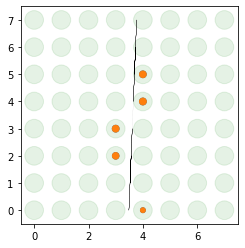

run 248  eventCount= 29
i 17  kx 4 ky 5 TOA 155.0 TOT 30.0    intime
i 18  kx 3 ky 7 TOA 156.0 TOT 19.0    intime
i 43  kx 2 ky 0 TOA 150.0 TOT 29.0    intime
i 45  kx 3 ky 0 TOA 152.0 TOT 42.0    intime
run 248  eventCount= 29 (orange: TOA intime)
s_x  0.132 i_x  2.605  err  0.133 r  0.574


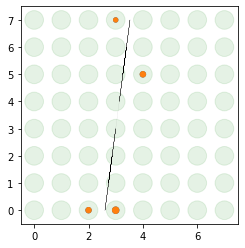

run 248  eventCount= 48
i 21  kx 5 ky 4 TOA 151.0 TOT 19.0    intime
i 23  kx 5 ky 5 TOA 138.0 TOT 47.0    intime
i 53  kx 5 ky 0 TOA 140.0 TOT 38.0    intime
i 55  kx 5 ky 1 TOA 135.0 TOT 48.0    intime
run 248  eventCount= 48 (orange: TOA intime)
s_x  0.000 i_x  5.000  err  0.000 r  0.000


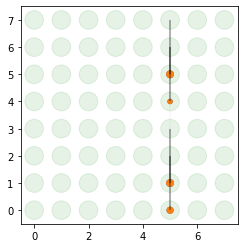

run 248  eventCount= 53
i 16  kx 3 ky 6 TOA 148.0 TOT 21.0    intime
i 19  kx 4 ky 4 TOA 144.0 TOT 37.0    intime
i 49  kx 4 ky 1 TOA 145.0 TOT 23.0    intime
i 50  kx 3 ky 3 TOA 138.0 TOT 47.0    intime
run 248  eventCount= 53 (orange: TOA intime)
s_x -0.154 i_x  4.038  err  0.163 r -0.555


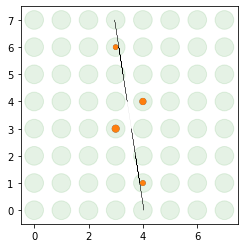

Run 248 ,   655  events have been analyzed.
start analyzing Run 249
/Users/kunori/skdir/CAEN/dfiles/MuonTestStand/Run249_list.csv
run 249  eventCount= 2
i 22  kx 2 ky 6 TOA 138.0 TOT 39.0    intime
i 24  kx 1 ky 6 TOA 146.0 TOT 39.0    intime
i 57  kx 6 ky 1 TOA 129.0 TOT 67.0    intime
i 59  kx 6 ky 0 TOA 129.0 TOT 92.0    intime
i 61  kx 7 ky 0 TOA 138.0 TOT 32.0    intime
i 63  kx 7 ky 1 TOA 155.0 TOT 40.0    intime
run 249  eventCount= 2 (orange: TOA intime)
s_x -0.887 i_x  6.903  err  0.118 r -0.966


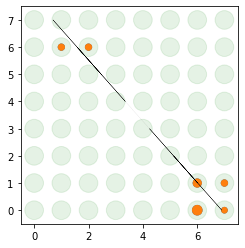

run 249  eventCount= 14
i 12  kx 4 ky 7 TOA 157.0 TOT 28.0    intime
i 13  kx 3 ky 4 TOA 151.0 TOT 44.0    intime
i 14  kx 4 ky 6 TOA 162.0 TOT 16.0     
i 15  kx 3 ky 5 TOA 159.0 TOT 27.0    intime
i 44  kx 4 ky 3 TOA 154.0 TOT 39.0    intime
i 45  kx 3 ky 0 TOA 156.0 TOT 37.0    intime
run 249  eventCount= 14 (orange: TOA intime)
s_x  0.090 i_x  3.060  err  0.111 r  0.423


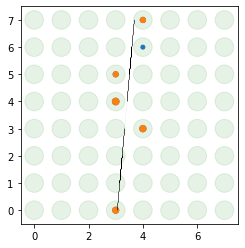

run 249  eventCount= 15
i 18  kx 3 ky 7 TOA 151.0 TOT 22.0    intime
i 19  kx 4 ky 4 TOA 158.0 TOT 11.0    intime
i 55  kx 5 ky 1 TOA 149.0 TOT 19.0    intime
i 59  kx 6 ky 0 TOA 147.0 TOT 22.0    intime
run 249  eventCount= 15 (orange: TOA intime)
s_x -0.400 i_x  5.700  err  0.058 r -0.980


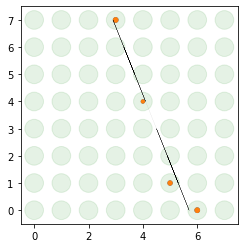

run 249  eventCount= 21
i 1  kx 0 ky 5 TOA 152.0 TOT 20.0    intime
i 3  kx 0 ky 4 TOA 156.0 TOT 17.0    intime
i 37  kx 1 ky 0 TOA 143.0 TOT 45.0    intime
i 39  kx 1 ky 1 TOA 148.0 TOT 39.0    intime
run 249  eventCount= 21 (orange: TOA intime)
s_x -0.235 i_x  1.088  err  0.042 r -0.970


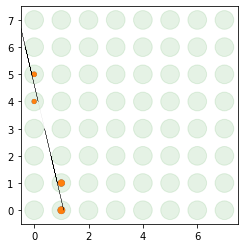

run 249  eventCount= 33
i 14  kx 4 ky 6 TOA 150.0 TOT 19.0    intime
i 15  kx 3 ky 5 TOA 140.0 TOT 66.0    intime
i 19  kx 4 ky 4 TOA 145.0 TOT 39.0    intime
i 44  kx 4 ky 3 TOA 147.0 TOT 33.0    intime
i 48  kx 3 ky 2 TOA 136.0 TOT 50.0    intime
i 55  kx 5 ky 1 TOA 143.0 TOT 36.0    intime
run 249  eventCount= 33 (orange: TOA intime)
s_x -0.143 i_x  4.333  err  0.188 r -0.355


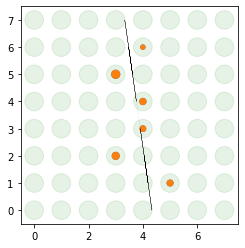

run 249  eventCount= 36
i 11  kx 2 ky 4 TOA 144.0 TOT 53.0    intime
i 14  kx 4 ky 6 TOA 152.0 TOT 33.0    intime
i 18  kx 3 ky 7 TOA 152.0 TOT 49.0    intime
i 37  kx 1 ky 0 TOA 151.0 TOT 38.0    intime
i 39  kx 1 ky 1 TOA 154.0 TOT 32.0    intime
run 249  eventCount= 36 (orange: TOA intime)
s_x  0.387 i_x  0.806  err  0.105 r  0.905


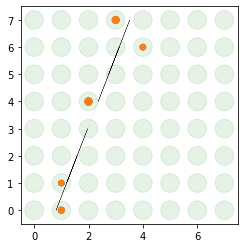

run 249  eventCount= 37
i 13  kx 3 ky 4 TOA 151.0 TOT 17.0    intime
i 14  kx 4 ky 6 TOA 146.0 TOT 30.0    intime
i 45  kx 3 ky 0 TOA 142.0 TOT 42.0    intime
i 46  kx 4 ky 2 TOA 141.0 TOT 41.0    intime
i 47  kx 3 ky 1 TOA 146.0 TOT 23.0    intime
run 249  eventCount= 37 (orange: TOA intime)
s_x  0.121 i_x  3.086  err  0.111 r  0.531


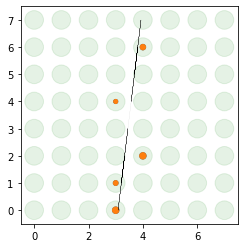

Run 249 ,   645  events have been analyzed.

 Total events in this job 6592
for runs [240 241 242 243 244 245 246 247 248 249]


Warning in <TFile::Append>: Replacing existing TH1: toa_2hits (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: toa_2hits_deltaT (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: toa_deltaT (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: tot_2hits (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: toa_2hits (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: toa_2hits_deltaT (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: toa_deltaT (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: tot_2hits (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: toa_2hits (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: toa_2hits_deltaT (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: toa_deltaT (Potential memory leak).
Warning in <TFile::

In [4]:
displayDone=0


oname="histMuonAnalysis_Run"+str(runlist[0])+".root"
ofile=ROOT.TFile(oname,"RECREATE")

def displayHits(run,eventCount,TOT,TOA):
    global displayDone,nhitDisplay,nhitDisplayMax
    global rangeTOA

    if displayDone>0:
        return
    displayDone=1   # set flag to avoid same event displayed multiple times.

    nhitDisplay=nhitDisplay+1
    if nhitDisplay>nhitDisplayMax:
        return
    
    TOTtemp=np.copy(TOT)
    TOTtempGoodTOA=np.copy(TOT)
    for i in np.arange(0,64,1):
        if TOA[i]<rangeTOA[0] or TOA[i]>rangeTOA[1]:
            TOTtempGoodTOA[i]=0.0  # reset value if TOA does no exist
    TOTmax=np.amax(TOTtemp)
    
    x=np.zeros(64)
    y=np.zeros(64)
    z=np.zeros(64)
    ztoa=np.zeros(64)
    zhole=np.zeros(64)
    
    xf=np.zeros(64)
    yf=np.zeros(64)
    zf=np.zeros(64)
    nf=0
    
    print("run",run," eventCount=",eventCount)
    for i in range(0,64):
        j=caen2xy[i]
        kx=int(j%8)
        ky=int(j/8)
        x[i]=float(kx)
        y[i]=float(ky)
        z[i]=TOTtemp[i]
        ztoa[i]=TOTtempGoodTOA[i]
        zhole[i]=700.0*2.0/4.0
        intime=" "
        if TOTtempGoodTOA[i]>0.0:
            intime="intime"
            xf[nf]=x[i]
            yf[nf]=y[i]
            zf[nf]=TOT[i]
            nf=nf+1
        if TOTtemp[i]>0.0:
            print("i",i," kx",kx,"ky",ky,"TOA",TOA[i],"TOT",TOT[i],"  ",intime)
    print("run",run," eventCount=",eventCount,"(orange: TOA intime)")
    xf2=xf[:nf]
    yf2=yf[:nf]
    zf2=zf[:nf]
    res=stats.linregress(yf2,xf2)
    # print("slope",res.slope,"interc",res.intercept,"serr",res.stderr, "r",res.rvalue)
    print("s_x {:6.3f} i_x {:6.3f}  err {:6.3f} r {:6.3f}"
          .format(res.slope,res.intercept,res.stderr,res.rvalue))
    plt.scatter(x,y,zhole,color="g",alpha=0.10)
    plt.scatter(x,y,z)
    plt.scatter(x,y,ztoa)
    plt.plot(res.intercept+res.slope*y,y,"k:",lw=0.1)
    plt.xlim(-0.5,7.5)
    plt.ylim(-0.5,7.5)
    plt.gca().set_aspect('equal')
    plt.show()
    return

def doLineFit(run,eventCount,TOT,TOA,HG,LG):
    global displayDone,nhitDisplay,nhitDisplayMax
    global rangeTOA
    
    TOTtemp=np.copy(TOT)
    TOTtempGoodTOA=np.copy(TOT)
    for i in np.arange(0,64,1):
        if TOA[i]<rangeTOA[0] or TOA[i]>rangeTOA[1]:
            TOTtempGoodTOA[i]=0.0  # reset value if TOA does no exist
    TOTmax=np.amax(TOTtemp)
    
    x=np.zeros(64)
    y=np.zeros(64)
    z=np.zeros(64)
    ztoa=np.zeros(64)
    
    xf=np.zeros(64)
    yf=np.zeros(64)
    zf=np.zeros(64)
    nf=0
    
    # print("run",run," eventCount=",eventCount)
    for i in range(0,64):
        j=caen2xy[i]
        kx=int(j%8)
        ky=int(j/8)
        x[i]=float(kx)
        y[i]=float(ky)
        z[i]=TOTtemp[i]
        ztoa[i]=TOTtempGoodTOA[i]
        if TOTtempGoodTOA[i]>0.0:
            xf[nf]=x[i]
            yf[nf]=y[i]
            zf[nf]=TOT[i]
            nf=nf+1

    if nf<4:
        return
    
    xf2=xf[:nf]
    yf2=yf[:nf]
    zf2=zf[:nf]
    res=stats.linregress(yf2,xf2)
    # print("slope",res.slope,"interc",res.intercept,"serr",res.stderr, "r",res.rvalue)
    # print("s_x {:6.3f} i_x {:6.3f}  err {:6.3f} r {:6.3f}"
    #      .format(res.slope,res.intercept,res.stderr,res.rvalue))

    if res.stderr<0.2:
        displayHits(run,eventCount,TOT,TOA)
        fltTOA= (TOA > rangeTOA[0]) & (TOA < rangeTOA[1])
        goodTOA=TOA[fltTOA]
        goodTOT=TOT[fltTOA]
        goodHG=HG[fltTOA]
        meanTOA=np.mean(goodTOA)
        for ix, _toa in enumerate(goodTOA):
            dt=_toa-meanTOA
            h1["toa_deltaT"].Fill(dt)
            h2["dt_vs_TOT"].Fill(goodTOT[ix],dt)
            h2["TOT_vs_HG"].Fill(goodHG[ix],goodTOT[ix])
        
    return
        
def defineHistograms():
    global ofile
    global h1,h2,hp
    
    s="ChID"
    h1[s]=ROOT.TH1D(s,s,64,0.0,64.0)
    
    s="ChID_dtype3"
    h1[s]=ROOT.TH1D(s,s,64,0.0,64.0)
    
    for run in runlist:
        s="EventID_dtype3_Run"+str(run)
        h1[s]=ROOT.TH1D(s,s,500,0.0,500.0)

    s="data_type_all"
    h1[s]=ROOT.TH1D(s,s,5,0.0,5.0)
    
    s="data_type_max"
    h1[s]=ROOT.TH1D(s,s,5,0.0,5.0)
    
    s="dt_vs_TOT"
    h2[s]=ROOT.TH2D(s,s,100,0.0,100.0,80,-20.0,20.0)
    
    s="TOT_vs_HG"                        
    h2[s]=ROOT.TH2D(s,s,100,0.0,1000.0,100,0.0,100.0)
    
    s="HG_all"
    h1[s]=ROOT.TH1D(s,s,1100,0.0,1100.0)
    
    s="a_HG_all"
    h1[s]=ROOT.TH1D(s,s,500,0.0,500.0)
    
    s="toa_all"
    h1[s]=ROOT.TH1D(s,s,1100,0.0,1100.0)
    s="a_toa_all"
    h1[s]=ROOT.TH1D(s,s,500,0.0,500.0)
    
    s="tot_all"
    h1[s]=ROOT.TH1D(s,s,1100,0.00,1100.0)
    s="a_tot_all"
    h1[s]=ROOT.TH1D(s,s,200,0.00,200.0)
    
    s="tot_intime"
    h1[s]=ROOT.TH1D(s,s,1100,0.00,1100.0)
    s="a_tot_intime"
    h1[s]=ROOT.TH1D(s,s,200,0.00,200.0)

    for i in range(64):
        
        s="toa_"+str(i)
        h1[s]=ROOT.TH1D(s,s,1000,0.0,1000.0)
        s="tot_"+str(i)
        h1[s]=ROOT.TH1D(s,s,1000,0.0,1000.0)
        
        s="a_toa_"+str(i)
        h1[s]=ROOT.TH1D(s,s,500,0.0,5000.0)
        s="a_tot_"+str(i)
        h1[s]=ROOT.TH1D(s,s,100,0.0,100.0) 
        
        #
        #  for AnalyzeTOA
        #
        
        s="toa_2hits"        
        h1[s]=ROOT.TH1D(s,s,100,0.0,400.0)
        
        s="toa_2hits_deltaT"        
        h1[s]=ROOT.TH1D(s,s,100,-50.0,50.0)
        
        s="toa_deltaT"        
        h1[s]=ROOT.TH1D(s,s,100,-50.0,50.0)

        s="tot_2hits"        
        h1[s]=ROOT.TH1D(s,s,100,0.0,100.0)
    return

#   define all histograms here.
defineHistograms()

def analyzeTOA(run,eventCount,LG,HG,TOA,TOT,data_type):
    global h1,h2,hp
    global rangeTOA
    
    tempTOA=np.copy(TOA)
    toaMax=np.amax(TOA)
    if toaMax < 1.0:        # skip event without TOA
        return
    
    nIX=np.zeros(8,dtype=int)
    toaIX=np.zeros((8,8))
    totIX=np.zeros((8,8))
    
    nIXintime=np.zeros(8,dtype=int)
    toaIXintime=np.zeros((8,8))
    totIXintime=np.zeros((8,8))
    
    for i in range(0,64):
        j=caen2xy[i]
        kx=int(j%8)
        ky=int(j/8)
        if tempTOA[i]>1.0:
            # print("eventCount",eventCount,"kx",kx,"ky",ky,tempTOA[i])
            toaIX[nIX[kx],kx]=tempTOA[i]
            totIX[nIX[kx],kx]=TOT[i]
            nIX[kx]=nIX[kx]+1
            if tempTOA[i]>rangeTOA[0] and tempTOA[i]<rangeTOA[1]:
                toaIXintime[nIXintime[kx],kx]=tempTOA[i]
                totIXintime[nIXintime[kx],kx]=TOT[i]
                nIXintime[kx]=nIXintime[kx]+1

    
    nTotal=np.sum(nIXintime)
    # print("eventCount",eventCount,"  nTotal=",nTotal)
    if nTotal >= 3 and nTotal < 10 :
        for kx in range(0,8):   
            if(nIXintime[kx]>=2):
                # print("eventCount",eventCount,"  nTotal=",nTotal)
                delta=toaIXintime[0,kx]-toaIXintime[1,kx]
                s="toa_2hits_deltaT"
                h1[s].Fill(delta)
                # print("DeltaTOA: {:6.1f} toa {:6.1f} {:6.1f} kx {:2d}"
                #      .format(delta,toaIX[0,kx],toaIX[1,kx],kx))
                # print("TOT:    {:6.1f} {:6.1f}"
                #      .format(totIX[0,kx],totIX[1,kx]))
                for j in range(0,nIXintime[kx]):
                    s="toa_2hits"        
                    h1[s].Fill(toaIXintime[j,kx])        
                    s="tot_2hits"        
                    h1[s].Fill(totIXintime[j,kx])
                
                #  displayHits(run,eventCount,TOT,TOA)   #   display hits
        
    return

def fillHistograms(run,eventCount,LG,HG,TOA,TOT,data_type):
    global h1,h2,hp
    
    datatypemax=np.amax(data_type)
    h1["data_type_max"].Fill(datatypemax)
    
    if datatypemax==3:
        s="EventID_dtype3_Run"+str(run)
        h1[s].Fill(eventCount)
    
    for i in range(0,64):
        h1["data_type_all"].Fill(data_type[i])
        if data_type[i]==3:
            h1["ChID_dtype3"].Fill(i)

        if HG[i]>0.0:      
            h1["HG_all"].Fill(HG[i])
            h1["a_HG_all"].Fill(HG[i])          
                    
        if TOA[i]>0.0:      
            h1["toa_all"].Fill(TOA[i])
            h1["a_toa_all"].Fill(TOA[i])
            s="toa_"+str(i)
            h1[s].Fill(TOA[i])
            s="a_toa_"+str(i)
            h1[s].Fill(TOA[i])

        if TOT[i]>0.0:
            h1["tot_all"].Fill(TOT[i])
            h1["a_tot_all"].Fill(TOT[i])
            
            if TOA[i]>rangeTOA[0] and TOA[i]<rangeTOA[1]:
                h1["tot_intime"].Fill(TOT[i])
                h1["a_tot_intime"].Fill(TOT[i])
            
            s="tot_"+str(i)
            h1[s].Fill(TOT[i])
            s="a_tot_"+str(i)
            h1[s].Fill(TOT[i])
            
        
    #  return to caller.
    return
    


def analyzeRun(run):
    global displayDone,nhitDisplay
    global lastEventCount
    global nmaxEventsPerRun
    

    
    csvname=csvdir+"Run"+str(run)+"_list.csv"
    print("start analyzing Run",run)
    print(csvname)
    
    eventCount=0
    with open(csvname,"r") as csvfile:
        reader=csv.reader(csvfile)
        nhitDisplay=0   # reset the display counter for new run.
        for ix, row in enumerate(reader):
            displayDone=0
            # print(ix,"  ",row)
            if ix<5:
                continue
                
            if ix>nmaxEventsPerRun:
                break
            eventCount=eventCount+1
            rtcode,TStamp,LG,HG,TOA,TOT,data_type=unpackData(row)
            # print("TOA ",TOA," TOT ",TOT)
            if rtcode>0:
                print("return code from unpackData is ",rtcode," Abort this job.")
                break

            fillHistograms(run,eventCount,LG,HG,TOA,TOT,data_type)
            analyzeTOA(run,eventCount,LG,HG,TOA,TOT,data_type)
            doLineFit(run,eventCount,TOT,TOA,HG,LG)
              
            TOTtemp=np.copy(TOT)
            for i in np.arange(0,64,1):
                if TOA[i]<0.1 or TOA[i]>5000.0:
                    TOTtemp[i]=0.0
            TOTmax=np.amax(TOTtemp)
            
            if TOTmax>10000.0:
                displayHits(run,eventCount,TOT,TOA)
                
    return eventCount
                
#  loop over all events to analyze.
nTotal=0
for ix,run in enumerate(runlist):
    eventCount= analyzeRun(run)
    runEventCount[ix]=eventCount
    nTotal=nTotal+eventCount
    print("Run",run,",  ",eventCount," events have been analyzed.")

    totalEventCount=nTotal
# write histograms to output root histogram file
print("\n Total events in this job",nTotal)
print("for runs",runlist)
#  ofile.Write()

# 8x8 display shows hits with amplitude > 120 ( >= 1 pe)

run list: [240 241 242 243 244 245 246 247 248 249]
 number of events: [665. 635. 649. 635. 668. 660. 660. 720. 655. 645.]
total events= 6592


Info in <TCanvas::Print>: pdf file plotdir/plotMTS_run240_01_eventIDvsTOA.pdf has been created


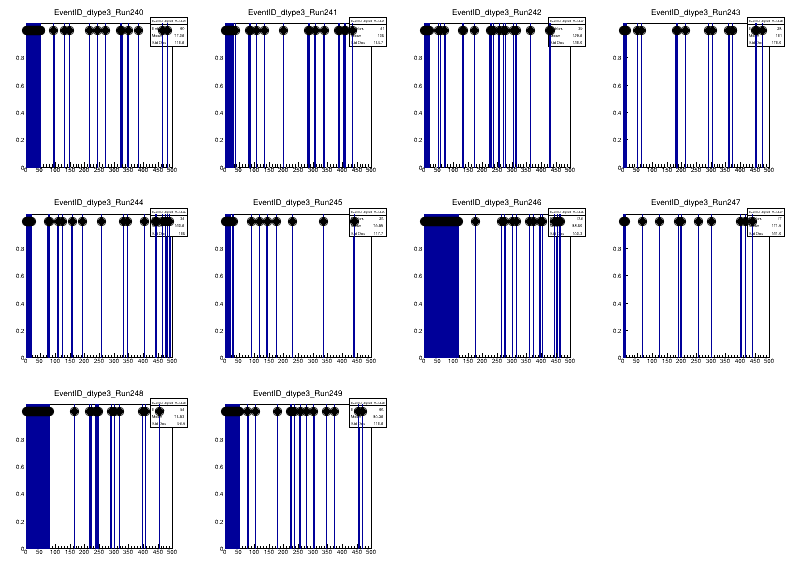

In [5]:
c11 = ROOT.TCanvas("c11","EventIDTOA",800,600)
nx=4
ny=int((len(runlist)-1)/nx)
ny=ny+1
c11.Divide(nx,ny)
print("run list:",runlist)
print(" number of events:",runEventCount)
print("total events=",totalEventCount)

for ix in range(len(runlist)):
    run=runlist[ix]
    k=ix+1
    c11.cd(k)
    s="EventID_dtype3_Run"+str(run)
    h1[s].Draw("")
    h1[s].SetMarkerStyle(0)
    
    ss="lastevent"+str(run)
    h1[ss]=h1[s].Clone(ss)
    h1[ss].Clear()
    x=float(runEventCount[ix])
    wt=float(0.3)
    h1[ss].Fill(x,wt)
    
    h1[ss].Draw("SAME")
    h1[ss].SetMarkerStyle(20)

c11.Draw()

pdfname=prepdf+"01_eventIDvsTOA"+postpdf
c11.SaveAs(pdfname)

Info in <TCanvas::Print>: pdf file plotdir/plotMTS_run240_02_TOA_TOT.pdf has been created


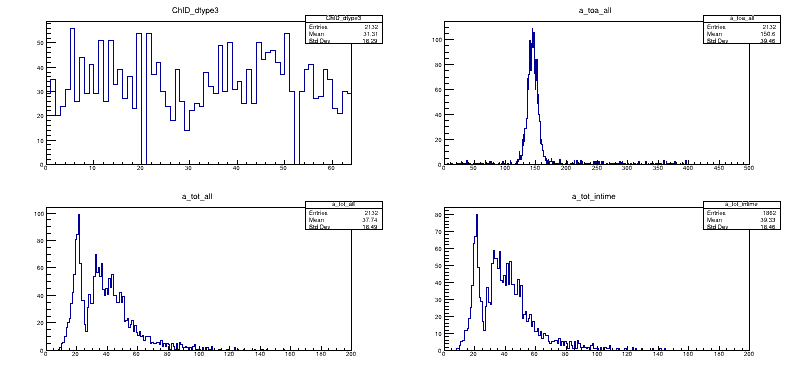

In [6]:
c3 = ROOT.TCanvas("c3","TOA-TOT",800,400)

c3.Divide(2,2)
c3.cd(1)
s="ChID_dtype3"
h1[s].Draw()
c3.cd(2)
s="a_toa_all"
h1[s].Draw()
c3.cd(3)
s="a_tot_all"
h1[s].Draw()
c3.cd(4)
s="a_tot_intime"
h1[s].Draw()


c3.Draw()

pdfname=prepdf+"02_TOA_TOT"+postpdf
c3.SaveAs(pdfname)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3
Info in <TCanvas::Print>: pdf file plotdir/plotMTS_run240_03_deltaTOA.pdf has been created


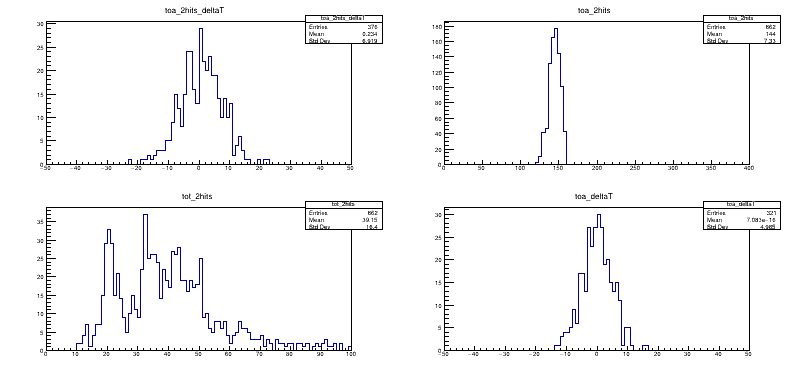

In [7]:
c3 = ROOT.TCanvas("c3","TOAdelta",800,400)

c3.Divide(2,2)
c3.cd(1)
s="toa_2hits_deltaT"
h1[s].Draw()
c3.cd(2)
s="toa_2hits"
h1[s].Draw()
c3.cd(3)
s="tot_2hits"
h1[s].Draw()
c3.cd(4)
s="toa_deltaT"
h1[s].Draw()

c3.Draw()

pdfname=prepdf+"03_deltaTOA"+postpdf
c3.SaveAs(pdfname)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3
Info in <TCanvas::Print>: pdf file plotdir/plotMTS_run240_04_TOA_i.pdf has been created


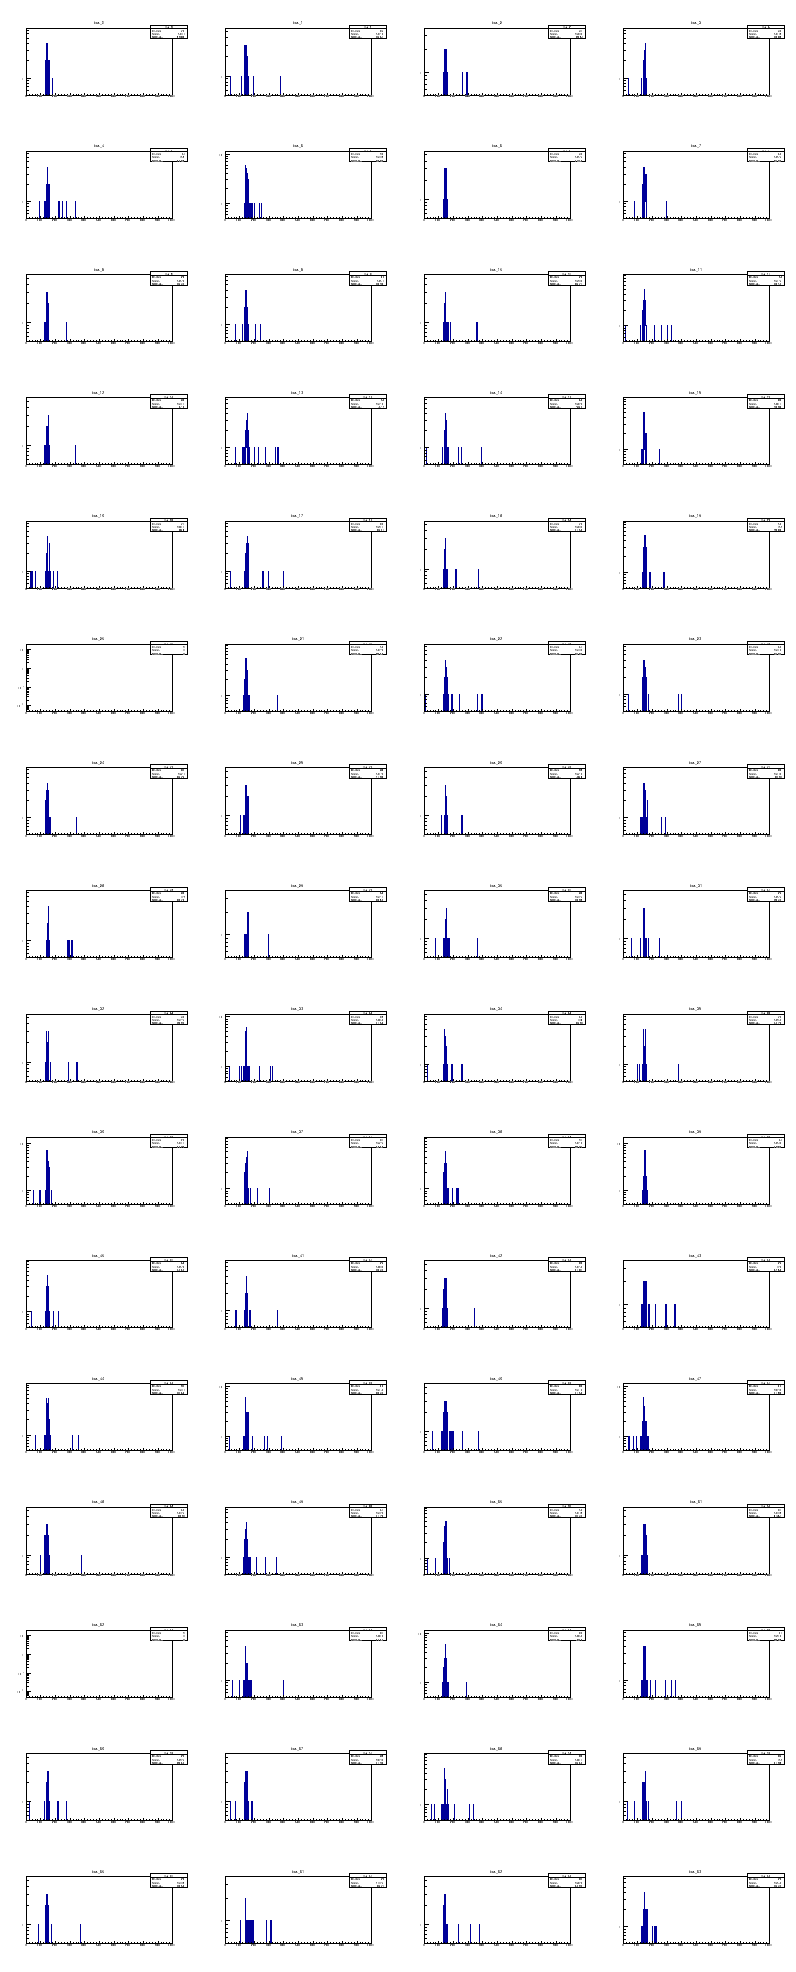

In [8]:
c3 = ROOT.TCanvas("c3","TOA",800,2000)

c3.Divide(4,16)
for i in range(64):
    c3.cd(i+1)
    c3.GetPad(i+1).SetLogy()
    s="toa_"+str(i)
    h1[s].Draw()
c3.Draw()

pdfname=prepdf+"04_TOA_i"+postpdf
c3.SaveAs(pdfname)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3
Info in <TCanvas::Print>: pdf file plotdir/plotMTS_run240_05_TOT_i.pdf has been created


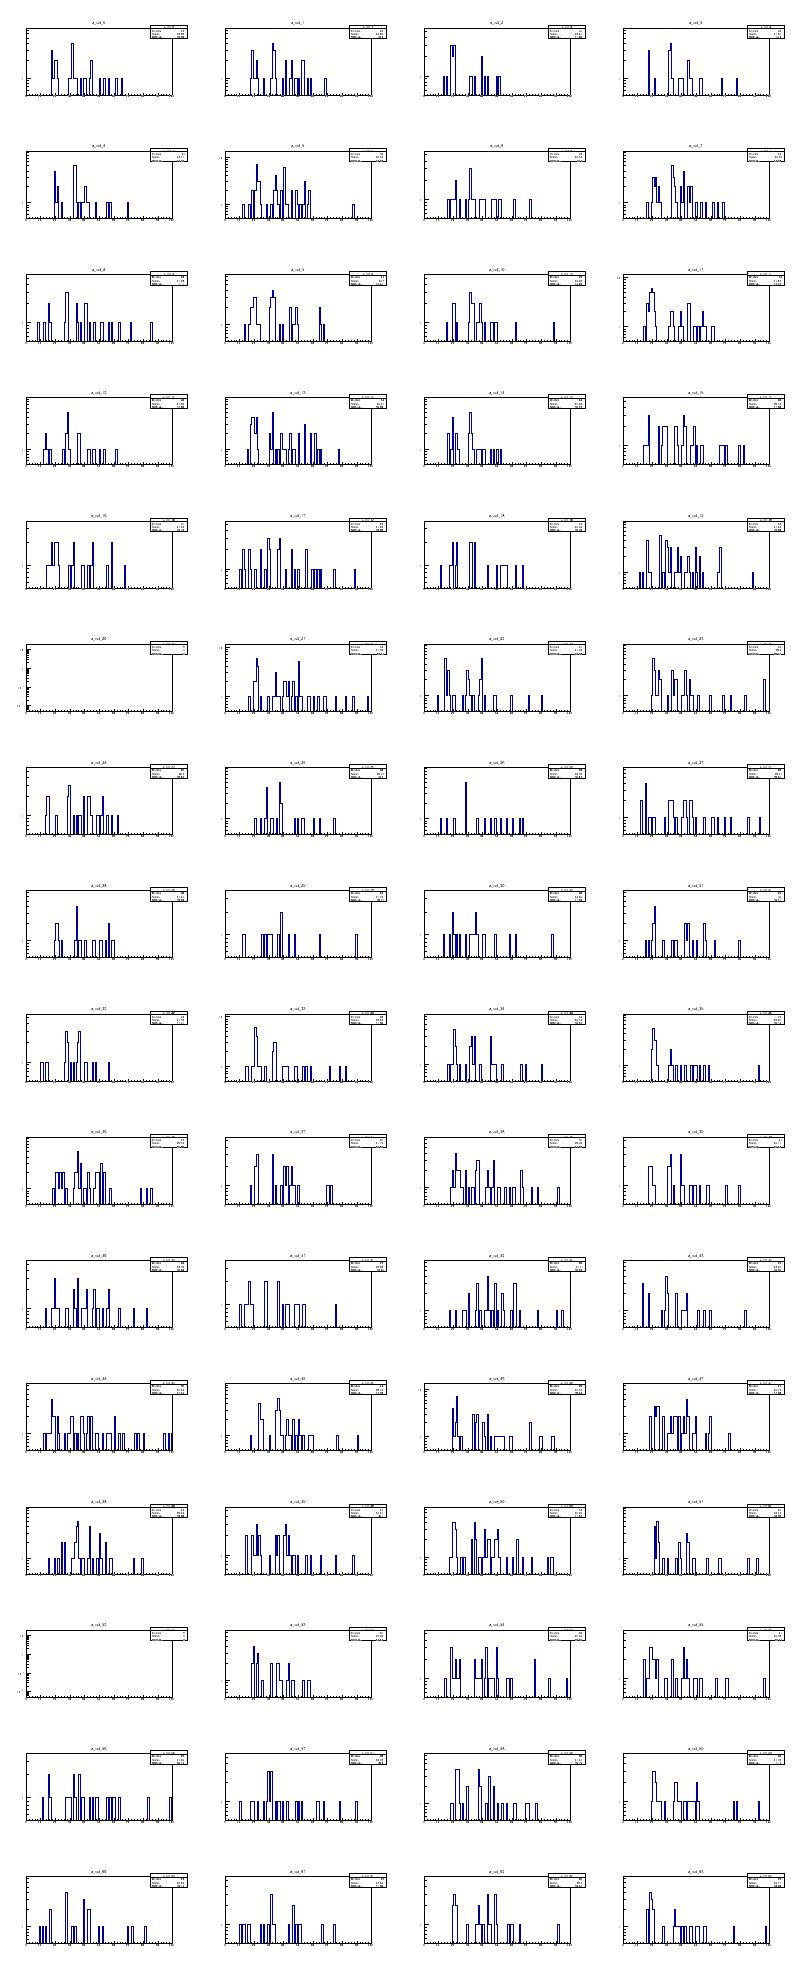

In [9]:
c3 = ROOT.TCanvas("c3","TOT",800,2000)

c3.Divide(4,16)
for i in range(64):
    c3.cd(i+1)
    c3.GetPad(i+1).SetLogy()
    s="a_tot_"+str(i)
    h1[s].Draw()
c3.Draw()

pdfname=prepdf+"05_TOT_i"+postpdf
c3.SaveAs(pdfname)

In [10]:
ofile.Write()
ofile.Close()